In [5]:
!pip install numpy pandas matplotlib networkx gymnasium stable-baselines3

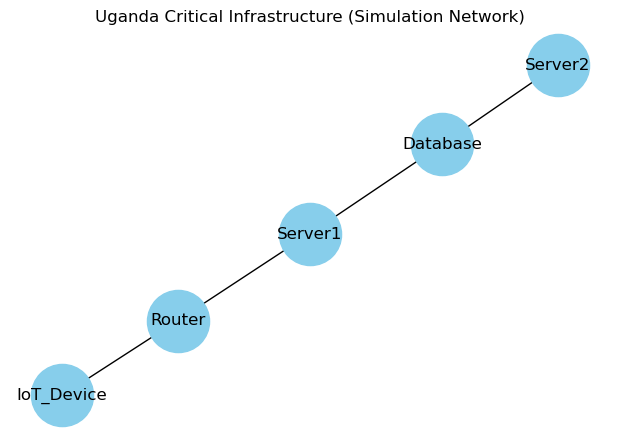

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Create an empty network graph
network = nx.Graph()

# Step 2: Add nodes (representing devices in Uganda's critical infrastructure)
nodes = ["Server1", "Server2", "Database", "IoT_Device", "Router"]
network.add_nodes_from(nodes)

# Step 3: Add edges (connections between devices)
edges = [("Server1", "Database"), ("Server2", "Database"),
         ("Server1", "Router"), ("IoT_Device", "Router")]
network.add_edges_from(edges)

# Step 4: Visualize the network
plt.figure(figsize=(6,4))
nx.draw(network, with_labels=True, node_color='skyblue', node_size=2000, font_size=12)
plt.title("Uganda Critical Infrastructure (Simulation Network)")
plt.show()


In [17]:
import random

# Step 1: Define possible traffic types
traffic_types = ["normal", "phishing", "ransomware", "ddos"]

# Step 2: Function to simulate traffic events
def generate_traffic(num_events=20):
    traffic_events = []
    for i in range(num_events):
        src = random.choice(nodes)  # pick random source
        dst = random.choice(nodes)  # pick random destination
        while dst == src:
            dst = random.choice(nodes)
        traffic_type = random.choices(traffic_types, weights=[0.7, 0.1, 0.1, 0.1])[0]  # 70% normal, 30% attack
        traffic_events.append({"source": src, "destination": dst, "type": traffic_type})
    return traffic_events

# Step 3: Generate sample traffic
sample_traffic = generate_traffic(10)

# Step 4: Display traffic events
for event in sample_traffic:
    print(event)


{'source': 'Server2', 'destination': 'Server1', 'type': 'normal'}
{'source': 'Router', 'destination': 'Server1', 'type': 'normal'}
{'source': 'Server2', 'destination': 'IoT_Device', 'type': 'normal'}
{'source': 'Server2', 'destination': 'IoT_Device', 'type': 'ddos'}
{'source': 'Router', 'destination': 'Server1', 'type': 'normal'}
{'source': 'Database', 'destination': 'Server2', 'type': 'normal'}
{'source': 'Server1', 'destination': 'IoT_Device', 'type': 'ddos'}
{'source': 'Router', 'destination': 'Database', 'type': 'normal'}
{'source': 'Router', 'destination': 'IoT_Device', 'type': 'phishing'}
{'source': 'Server2', 'destination': 'Database', 'type': 'normal'}


In [18]:
# Step 1: Simple Defense Agent
class DefenseAgent:
    def __init__(self):
        self.blocked = 0
        self.allowed = 0
        self.false_positives = 0
        self.detected_attacks = 0

    def inspect_traffic(self, event):
        # Simple rule: block if traffic is NOT 'normal'
        if event['type'] != 'normal':
            self.blocked += 1
            self.detected_attacks += 1
            action = "BLOCKED"
        else:
            self.allowed += 1
            action = "ALLOWED"
        return action

    def report(self):
        total = self.blocked + self.allowed
        detection_rate = (self.detected_attacks / (total if total else 1)) * 100
        print("\n--- Defense Report ---")
        print(f"Total Traffic: {total}")
        print(f"Allowed: {self.allowed}")
        print(f"Blocked: {self.blocked}")
        print(f"Detection Rate: {detection_rate:.2f}%")

# Step 2: Test the Agent
agent = DefenseAgent()

for event in sample_traffic:
    decision = agent.inspect_traffic(event)
    print(f"Traffic {event} -> {decision}")

agent.report()


Traffic {'source': 'Server2', 'destination': 'Server1', 'type': 'normal'} -> ALLOWED
Traffic {'source': 'Router', 'destination': 'Server1', 'type': 'normal'} -> ALLOWED
Traffic {'source': 'Server2', 'destination': 'IoT_Device', 'type': 'normal'} -> ALLOWED
Traffic {'source': 'Server2', 'destination': 'IoT_Device', 'type': 'ddos'} -> BLOCKED
Traffic {'source': 'Router', 'destination': 'Server1', 'type': 'normal'} -> ALLOWED
Traffic {'source': 'Database', 'destination': 'Server2', 'type': 'normal'} -> ALLOWED
Traffic {'source': 'Server1', 'destination': 'IoT_Device', 'type': 'ddos'} -> BLOCKED
Traffic {'source': 'Router', 'destination': 'Database', 'type': 'normal'} -> ALLOWED
Traffic {'source': 'Router', 'destination': 'IoT_Device', 'type': 'phishing'} -> BLOCKED
Traffic {'source': 'Server2', 'destination': 'Database', 'type': 'normal'} -> ALLOWED

--- Defense Report ---
Total Traffic: 10
Allowed: 7
Blocked: 3
Detection Rate: 30.00%


In [ ]:
import numpy as np
import random

# Define states and actions
traffic_states = ["normal", "phishing", "ransomware", "ddos"]
actions = [0, 1]  # 0=allow, 1=block

# Initialize Q-table
Q = np.zeros((len(traffic_states), len(actions)))

# Hyperparameters
alpha = 0.5      # learning rate
gamma = 0.8      # discount factor
epsilon = 0.2    # exploration rate
episodes = 500   # number of training episodes

# Reward function
def get_reward(traffic_type, action):
    if traffic_type == "normal" and action == 0:  # allow normal
        return 1
    elif traffic_type == "normal" and action == 1:  # block normal (false positive)
        return -1
    elif traffic_type != "normal" and action == 1:  # block attack
        return 1
    elif traffic_type != "normal" and action == 0:  # allow attack (missed)
        return -2

# Training loop
for ep in range(episodes):
    traffic = random.choice(traffic_states)  # random traffic type
    state = traffic_states.index(traffic)
    
    # Choose action (epsilon-greedy)
    if random.uniform(0,1) < epsilon:
        action = random.choice(actions)
    else:
        action = np.argmax(Q[state,:])
    
    # Get reward
    reward = get_reward(traffic, action)
    
    # Update Q-table
    Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[state,:]) - Q[state, action])

# After training, use the learned policy
print("Trained Q-Table:")
print(Q)

# Test the agent
def agent_decision(traffic_type):
    state = traffic_states.index(traffic_type)
    action = np.argmax(Q[state,:])
    return "BLOCK" if action == 1 else "ALLOW"

# Test on your sample traffic
print("\n--- Testing RL Agent on Sample Traffic ---")
for event in sample_traffic:
    decision = agent_decision(event['type'])
    print(f"Traffic {event} -> {decision}")


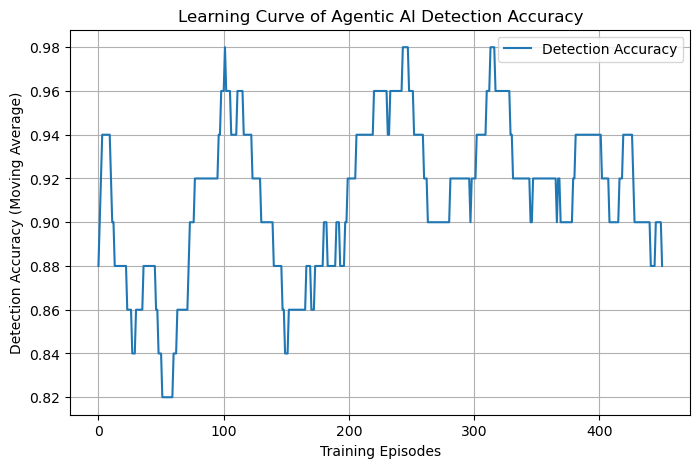

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Convert episode performance (1 = correct, 0 = incorrect) to moving average
window_size = 50  # smoothing window
moving_avg = np.convolve(episode_performance, np.ones(window_size)/window_size, mode='valid')

# Plot learning curve
plt.figure(figsize=(8, 5))
plt.plot(moving_avg, label="Detection Accuracy")
plt.xlabel("Training Episodes")
plt.ylabel("Detection Accuracy (Moving Average)")
plt.title("Learning Curve of Agentic AI Detection Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
plt.savefig("learning_curve_accuracy.png", dpi=300)

<Figure size 640x480 with 0 Axes>

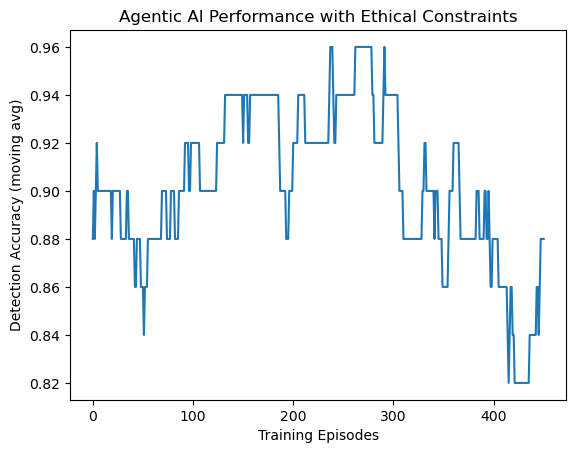

Retraining complete with ethical constraints applied.


In [20]:
import matplotlib.pyplot as plt

# Parameters
max_false_positive_rate = 0.3  # ethical rule: cannot block more than 30% normal traffic

# Logging performance
episode_performance = []

# Reset Q-table for retraining with ethical rules
Q = np.zeros((len(traffic_states), len(actions)))

for ep in range(episodes):
    traffic = random.choice(traffic_states)
    state = traffic_states.index(traffic)

    # Choose action
    if random.uniform(0,1) < epsilon:
        action = random.choice(actions)
    else:
        action = np.argmax(Q[state,:])
    
    # Apply ethical rule: limit blocking normal traffic
    if traffic == "normal" and action == 1 and random.random() < max_false_positive_rate:
        action = 0  # override: allow normal traffic
    
    # Get reward
    reward = get_reward(traffic, action)
    
    # Update Q
    Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[state,:]) - Q[state, action])

    # Track detection accuracy
    if traffic != "normal":
        correct = (action == 1)
    else:
        correct = (action == 0)
    episode_performance.append(1 if correct else 0)

# Plot performance over time
plt.plot(np.convolve(episode_performance, np.ones(50)/50, mode='valid'))
plt.xlabel("Training Episodes")
plt.ylabel("Detection Accuracy (moving avg)")
plt.title("Agentic AI Performance with Ethical Constraints")
plt.show()

print("Retraining complete with ethical constraints applied.")


In [13]:
import pandas as pd

# Logs
decision_log = []

def human_oversight(decision, traffic_event):
    # Simulate human review (for now, we just log it)
    return decision  # could override decisions in real system

# Test agent with human oversight
correct = 0
false_positives = 0
total_attacks = 0
detected_attacks = 0

for event in sample_traffic:
    ai_decision = agent_decision(event['type'])
    final_decision = human_oversight(ai_decision, event)

    # Log decisions
    decision_log.append({
        "source": event['source'],
        "destination": event['destination'],
        "traffic_type": event['type'],
        "ai_decision": ai_decision,
        "final_decision": final_decision
    })

    # Evaluate metrics
    if event['type'] != "normal":
        total_attacks += 1
        if final_decision == "BLOCK":
            detected_attacks += 1
    else:
        if final_decision == "BLOCK":
            false_positives += 1

# Calculate metrics
detection_rate = detected_attacks / (total_attacks if total_attacks else 1)
false_positive_rate = false_positives / len(sample_traffic)
ethical_score = 1 - false_positive_rate

# Display results
print("\n--- Final Agentic AI Simulation Metrics ---")
print(f"Detection Rate: {detection_rate:.2%}")
print(f"False Positive Rate: {false_positive_rate:.2%}")
print(f"Ethical Compliance Score: {ethical_score:.2%}")

# Save logs to CSV (for paper)
df = pd.DataFrame(decision_log)
df.to_csv("agentic_ai_decisions.csv", index=False)
print("Decisions logged to agentic_ai_decisions.csv")


--- Final Agentic AI Simulation Metrics ---
Detection Rate: 100.00%
False Positive Rate: 0.00%
Ethical Compliance Score: 100.00%
Decisions logged to agentic_ai_decisions.csv
